In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 73.80%
Success Probability Vector:
tensor([0.8221, 0.0010, 0.0464, 0.0013, 0.0147, 0.0050, 0.0017, 0.0228, 0.0775,
        0.0074], device='cuda:0')
Class 2 - Accuracy: 79.40%
Success Probability Vector:
tensor([5.2823e-04, 8.9811e-01, 1.0356e-06, 1.1331e-04, 7.2624e-06, 6.8284e-05,
        1.8017e-03, 4.1645e-05, 6.2272e-03, 9.3101e-02], device='cuda:0')
Class 3 - Accuracy: 51.30%
Success Probability Vector:
tensor([7.6693e-02, 2.3031e-05, 7.8094e-01, 5.2370e-03, 6.7974e-02, 4.0255e-03,
        2.7455e-02, 3.2127e-02, 5.4800e-03, 4.9263e-05], device='cuda:0')
Class 4 - Accuracy: 33.60%
Success Probability Vector:
tensor([0.0023, 0.0012, 0.0085, 0.6179, 0.0212, 0.2412, 0.0739, 0.0246, 0.0011,
        0.0081], device='cuda:0')
Class 5 - Accuracy: 74.70%
Success Probability Vector:
tensor([1.4862e-02, 1.9179e-04, 5.7735e-02, 2.0227e-02, 8.0929e-01, 1.9809e-02,
        3.0919e-02, 3.8927e-02, 5

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 30.116491317749023, Variance = 26.826976776123047, Min = 18.416927337646484, Max = 54.17702102661133
Class 1 (Failed): Mean = 27.16710662841797, Variance = 19.08940887451172, Min = 17.641948699951172, Max = 45.3980598449707
Class 2 (Successful): Mean = 40.572879791259766, Variance = 138.10284423828125, Min = 19.103092193603516, Max = 100.88411712646484
Class 2 (Failed): Mean = 30.384723663330078, Variance = 51.49161911010742, Min = 19.613862991333008, Max = 60.61767578125
Class 3 (Successful): Mean = 28.59091567993164, Variance = 26.789466857910156, Min = 20.130521774291992, Max = 54.94856262207031
Class 3 (Failed): Mean = 26.217945098876953, Variance = 21.498811721801758, Min = 17.997228622436523, Max = 51.48369598388672
Class 4 (Successful): Mean = 23.330514907836914, Variance = 6.5439772605896, Min = 18.070884704589844, Max = 34.9013786315918
Class 4 (Failed): Mean = 24.416770935058594, Variance = 8.16800594329834, Min = 17.866188049316406, Max = 38.8884

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'setting_3.pkl'
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[79.0, 70.0, 74.0, 74.0, 81.0, 74.0, 74.0, 79.0, 74.0, 81.0, 78.0, 71.0, 78.0, 72.0, 81.0, 80.0, 79.0, 79.0, 75.0, 79.0, 42.0, 40.0, 42.0, 50.0, 39.0, 45.0, 50.0, 39.0, 40.0, 40.0, 39.0, 42.0, 40.0, 40.0, 50.0, 47.0, 36.0, 47.0, 43.0, 38.0, 71.0, 70.0, 64.0, 67.0, 66.0, 74.0, 72.0, 71.0, 77.0, 77.0, 65.0, 78.0, 70.0, 75.0, 69.0, 76.0, 71.0, 73.0, 65.0, 74.0, 79.0, 84.0, 81.0, 83.0, 83.0, 78.0, 82.0, 85.0, 74.0, 82.0, 80.0, 80.0, 82.0, 81.0, 80.0, 79.0, 78.0, 84.0, 81.0, 83.0, 78.0, 83.0, 87.0, 85.0, 76.0, 81.0, 83.0, 82.0, 78.0, 83.0, 82.0, 87.0, 81.0, 79.0, 82.0, 74.0, 84.0, 81.0, 75.0, 84.0]
Before min/max/mean/std of accuracy
36.0 87.0 70.5 14.93


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 250, 1: 250}, 1: {0: 250, 1: 250}, 2: {0: 250, 1: 250}, 3: {0: 250, 1: 250}, 4: {0: 250, 1: 250}, 5: {0: 250, 1: 250}, 6: {0: 250, 1: 250}, 7: {0: 250, 1: 250}, 8: {0: 250, 1: 250}, 9: {0: 250, 1: 250}, 10: {0: 250, 1: 250}, 11: {0: 250, 1: 250}, 12: {0: 250, 1: 250}, 13: {0: 250, 1: 250}, 14: {0: 250, 1: 250}, 15: {0: 250, 1: 250}, 16: {0: 250, 1: 250}, 17: {0: 250, 1: 250}, 18: {0: 250, 1: 250}, 19: {0: 250, 1: 250}, 20: {2: 250, 3: 250}, 21: {2: 250, 3: 250}, 22: {2: 250, 3: 250}, 23: {2: 250, 3: 250}, 24: {2: 250, 3: 250}, 25: {2: 250, 3: 250}, 26: {2: 250, 3: 250}, 27: {2: 250, 3: 250}, 28: {2: 250, 3: 250}, 29: {2: 250, 3: 250}, 30: {2: 250, 3: 250}, 31: {2: 250, 3: 250}, 32: {2: 250, 3: 250}, 33: {2: 250, 3: 250}, 34: {2: 250, 3: 250}, 35: {2: 250, 3: 250}, 36: {2: 250, 3: 250}, 37: {2: 250, 3: 250}, 38: {2: 250, 3: 250}, 39: {2: 250, 3: 250}, 40: {4: 250, 5: 250}, 41: {4: 250, 5: 250}, 42: {4: 250, 5: 250}, 43: {4: 

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 50, 1: 50}, 1: {0: 50, 1: 50}, 2: {0: 50, 1: 50}, 3: {0: 50, 1: 50}, 4: {0: 50, 1: 50}, 5: {0: 50, 1: 50}, 6: {0: 50, 1: 50}, 7: {0: 50, 1: 50}, 8: {0: 50, 1: 50}, 9: {0: 50, 1: 50}, 10: {0: 50, 1: 50}, 11: {0: 50, 1: 50}, 12: {0: 50, 1: 50}, 13: {0: 50, 1: 50}, 14: {0: 50, 1: 50}, 15: {0: 50, 1: 50}, 16: {0: 50, 1: 50}, 17: {0: 50, 1: 50}, 18: {0: 50, 1: 50}, 19: {0: 50, 1: 50}, 20: {2: 50, 3: 50}, 21: {2: 50, 3: 50}, 22: {2: 50, 3: 50}, 23: {2: 50, 3: 50}, 24: {2: 50, 3: 50}, 25: {2: 50, 3: 50}, 26: {2: 50, 3: 50}, 27: {2: 50, 3: 50}, 28: {2: 50, 3: 50}, 29: {2: 50, 3: 50}, 30: {2: 50, 3: 50}, 31: {2: 50, 3: 50}, 32: {2: 50, 3: 50}, 33: {2: 50, 3: 50}, 34: {2: 50, 3: 50}, 35: {2: 50, 3: 50}, 36: {2: 50, 3: 50}, 37: {2: 50, 3: 50}, 38: {2: 50, 3: 50}, 39: {2: 50, 3: 50}, 40: {4: 50, 5: 50}, 41: {4: 50, 5: 50}, 42: {4: 50, 5: 50}, 43: {4: 50, 5: 50}, 44: {4: 50, 5: 50}, 45: {4: 50, 5: 50}, 46: {4: 50, 5: 50}, 47: {4: 50, 5: 

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.0629, -0.3142,  0.3274,  0.1656,  0.8649, -0.3926, -0.2118, -0.3100,
        -0.1514, -0.0204], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([1.8318, 2.2672, 2.6520, 2.7796, 3.2783, 2.5044, 2.8140, 2.0749, 2.4599,
        2.0143], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000,  0.3293,  0.0144, -0.4852, -0.1490, -0.2703, -0.1935,  0.0180,
          0.2582, -0.1043],
        [ 0.3293,  1.0000, -0.4591, -0.3923, -0.2825, -0.2722,  0.1121, -0.2444,
          0.1716,  0.2897],
        [ 0.0144, -0.4591,  1.0000,  0.3129, -0.0581, -0.1693, -0.0516, -0.0547,
          0.0190, -0.4347],
        [-0.4852, -0.3923,  0.3129,  1.0000, -0.1541,  0.2378, -0.0448, -0.0804,
         -0.2951, -0.1041],
        [-0.1490, -0.2825, -0.0581, -0.1541,  1.0000,  0.1111, -0.1659, -0.1508,
         -0.0195, -0.1582],
    

Weight norm of each class part of classifier
tensor([1.3534, 1.5057, 1.6285, 1.6672, 1.8106, 1.5825, 1.6775, 1.4405, 1.5684,
        1.4193], device='cuda:0', grad_fn=<SqrtBackward0>)


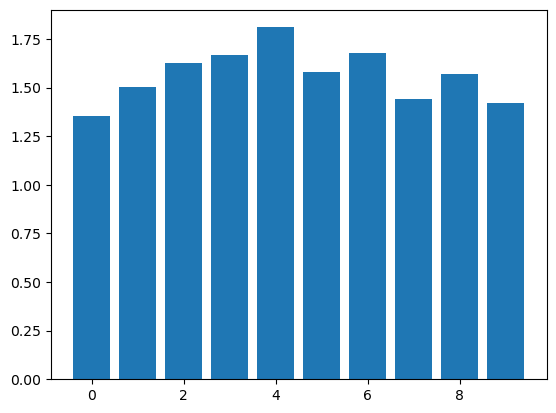

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

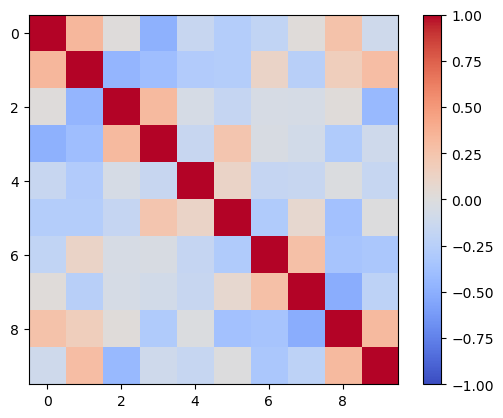

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.97618496, 1: 0.97061944, 2: 0.9765519, 3: 0.97605425, 4: 0.98269224, 5: 0.96702284, 6: 0.9818788, 7: 0.97729063, 8: 0.9797539, 9: 0.9616647}
-------------------VAR-------------------
{0: 0.00056277623, 1: 0.001356844, 2: 0.0005387167, 3: 0.00039999903, 4: 0.0002026616, 5: 0.0007469822, 6: 0.00029033548, 7: 0.00036083, 8: 0.00046622747, 9: 0.0014462891}


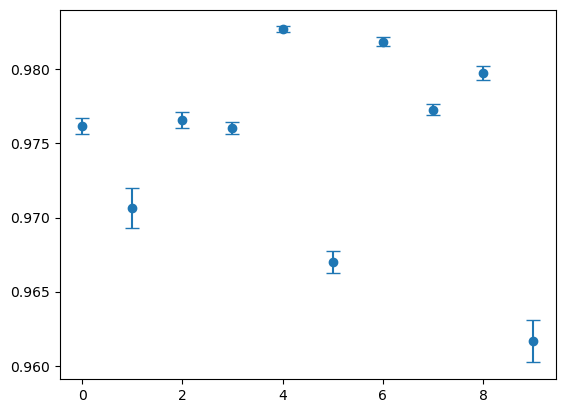

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'setting_3.pkl'
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([0.0000e+00, 6.6126e-01, 1.5787e+00, 3.6393e+00, 0.0000e+00, 0.0000e+00,
        7.2526e-04, 3.1080e+00, 2.6360e+00, 0.0000e+00, 2.0328e-01, 0.0000e+00,
        1.6414e+00, 1.0127e-01, 1.3231e-01, 1.7976e+00, 5.8877e-01, 6.8636e-01,
        5.6729e-03, 1.6733e+00, 0.0000e+00, 5.7660e-01, 3.4076e-02, 2.0616e+00,
        1.6485e+00, 1.0589e+00, 7.5372e-01, 1.3469e+00, 2.2763e+00, 7.5779e-01,
        0.0000e+00, 0.0000e+00, 2.6408e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.9054e-02, 0.0000e+00, 0.0000e+00, 7.0735e-01, 2.4302e+00, 0.0000e+00,
        0.0000e+00, 1.0187e+00, 2.0299e+00, 3.8934e-01, 0.0000e+00, 0.0000e+00,
        1.6317e+00, 9.4453e-02, 9.6117e-01, 1.4056e-01, 0.0000e+00, 0.0000e+00,
        1.0876e+00, 1.4251e+00, 4.1307e-01, 5.1386e+00, 2.0422e+00, 0.0000e+00,
        2.6141e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9749e-02, 0.0000e+00,
        6.5510e-01, 4.9536e-01, 1.4426e-

# Cosine Similarity of Centroid Vectors

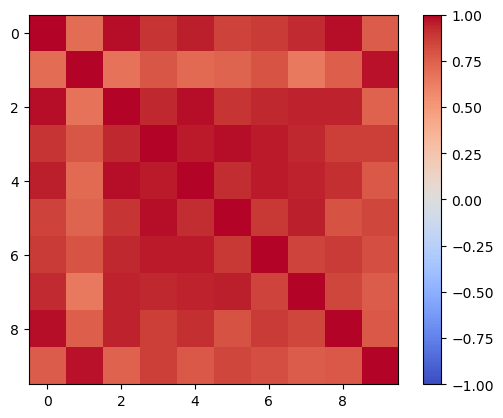

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.99999994 0.6968804  0.98012394 0.89778686 0.94851947 0.8590286
  0.88077605 0.9226564  0.97911483 0.76145184]
 [0.6968804  1.         0.6739134  0.787377   0.7094266  0.7341453
  0.78963935 0.6432102  0.75192547 0.97262174]
 [0.98012394 0.6739134  1.         0.93462527 0.9835131  0.8907944
  0.9315664  0.9404635  0.94308335 0.7402736 ]
 [0.89778686 0.787377   0.93462527 1.0000001  0.96087784 0.97867423
  0.9579946  0.9347831  0.86288404 0.8600633 ]
 [0.94851947 0.7094266  0.9835131  0.96087784 1.         0.91428685
  0.9558019  0.9448789  0.9101667  0.77754474]
 [0.8590286  0.7341453  0.8907944  0.97867423 0.91428685 1.
  0.8841157  0.9524963  0.79861253 0.8398711 ]
 [0.88077605 0.78963935 0.9315664  0.9579946  0.9558019  0.8841157
  1.         0.846597   0.87816083 0.8109411 ]
 [0.9226564  0.6432102  0.9404635  0.9347831  0.9448789  0.9524963
  0.846597   1.         0.8411754  0.7636061 ]
 [0.97911483 0.75192547 0.94308335 0.86288404 0.9101667  0.79861253
 

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.1932, 0.3675, 0.1170, 0.1094, 0.1070, 0.2272, 0.1730, 0.2410, 0.2181,
        0.3312], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.1932, 0.3675, 0.1170, 0.1094, 0.1070, 0.2272, 0.1730, 0.2410, 0.2181,
        0.3312], device='cuda:0', grad_fn=<DiagonalBackward0>)


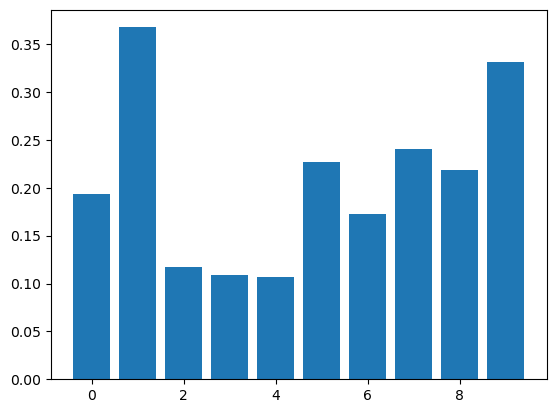

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Singular Value Analysis

Files already downloaded and verified
Files already downloaded and verified
['2.108', '1.898', '1.812', '1.564', '1.388', '1.310', '1.179', '1.128', '1.121', '1.096', '1.087', '1.083', '1.073', '1.069', '1.061', '1.059', '1.051', '1.049', '1.046', '1.041', '1.035', '1.032', '1.030', '1.021', '1.019', '1.015', '1.009', '1.004', '0.999', '0.998', '0.995', '0.990', '0.982', '0.978', '0.977', '0.971', '0.967', '0.964', '0.961', '0.959', '0.958', '0.952', '0.948', '0.943', '0.938', '0.936', '0.934', '0.931', '0.928', '0.926', '0.924', '0.921', '0.916', '0.914', '0.911', '0.911', '0.907', '0.902', '0.899', '0.898', '0.895', '0.891', '0.889', '0.885', '0.885', '0.881', '0.878', '0.876', '0.871', '0.871', '0.866', '0.865', '0.860', '0.856', '0.855', '0.851', '0.849', '0.847', '0.843', '0.842', '0.839', '0.832', '0.831', '0.828', '0.826', '0.823', '0.822', '0.815', '0.815', '0.814', '0.812', '0.809', '0.808', '0.805', '0.804', '0.802', '0.800', '0.796', '0.792', '0.791', '0.788', '0.785', '0.78

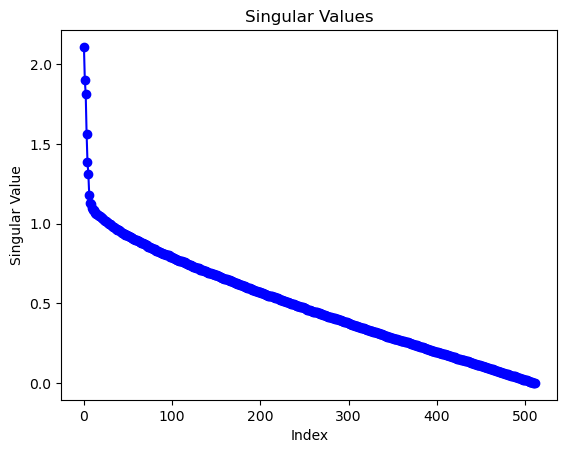

In [23]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()
                
                info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

                # Compute the singular value decomposition (SVD)
                _, s, _ = torch.svd(info_param[0])

                # Sort the singular values in descending order and store them in a list
                sorted_s = sorted(s.tolist(), reverse=True)
                
                print(["{:.3f}".format(num) for num in sorted_s])

                # Create a list of indices for the singular values
                indices = list(range(len(sorted_s)))

                # Plot the singular values with their indices
                plt.plot(indices, sorted_s, marker='o', linestyle='-', color='b')
                plt.xlabel('Index')
                plt.ylabel('Singular Value')
                plt.title('Singular Values')

                # Set x-axis ticks to display only integer values
#                 plt.xticks(indices)

                plt.show()

